# COMP7705 Project: (Re-)Imag(in)ing Price Trends

This jupyter notebook is composed of 5 parts.

1. Data processing
2. Baseline model (including model construction, training and testing)
3. Sensitivity analysis
4. Grad-CAM
5. Regression model


In [ ]:
# unzip the file
import os
from zipfile import ZipFile

extracted_dir = "./"
with ZipFile('datagood.zip', 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

## Data processing

In [3]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

image_dir = "./datagood/"
csv_file = "labels.csv"

# Load the CSV data
data_df = pd.read_csv(csv_file)

In [4]:
# Check the number of missing values in each column
data_df.isnull().sum()

Stock Code         0
Year               0
Month              0
Label         189865
Return             0
Rise               0
dtype: int64

In [5]:
# Create empty lists to store the image data and labels
image_data = []
labels = []

# Iterate through the CSV rows
for index, row in data_df.iterrows():
    stock_code = row["Stock Code"]
    year = row["Year"]
    month = row["Month"]

    # Construct the image filename
    image_filename = f"chart_{stock_code}_{year}_{month}.png"
    image_path = os.path.join(image_dir, image_filename)

    # Open and convert the image to binary format
    image = Image.open(image_path)
    image = image.resize((207, 101))
    image = image.convert('L')
    image_array = np.array(image)

    # Append the image data and label to the lists
    image_data.append(image_array)
    labels.append(row["Rise"])

# Convert the lists to NumPy arrays
image_data = np.array(image_data)
labels = np.array(labels)

# Split the data into training and testing sets (80:20 ratio)
split_ratio = 0.8
split_index = int(len(image_data) * split_ratio)

image_train_val_data = image_data[:split_index]
label_train_val_data = labels[:split_index]
image_test_data = image_data[split_index:]
label_test_data = labels[split_index:]

# Print the shape of the training and testing sets
print("Training Images:", image_train_val_data.shape)
print("Training Labels:", label_train_val_data.shape)
print("Testing Images:", image_test_data.shape)
print("Testing Labels:", label_test_data.shape)

Training Images: (151892, 101, 207)
Training Labels: (151892,)
Testing Images: (37973, 101, 207)
Testing Labels: (37973,)


In [6]:
import copy
data_df_temp = copy.deepcopy(data_df)

## Data EDA

In [7]:
data_df.drop(['Label'], axis=1,inplace=True)
data_df["Rise"] = data_df["Rise"].astype(int)
data_df.rename(columns={'Rise':'Label'},inplace=True)
data_df.tail(10)

,Stock Code,Year,Month,Return,Label
189855,688981.SH,2022,5,0.062438,1
189856,688981.SH,2022,6,0.056608,1
189857,688981.SH,2022,7,-0.105334,0
189858,688981.SH,2022,8,0.000747,1
189859,688981.SH,2022,9,-0.054318,0
189860,688981.SH,2023,1,0.007703,1
189861,688981.SH,2023,2,-0.033134,0
189862,688981.SH,2023,3,0.182676,1
189863,688981.SH,2023,4,0.128252,1
189864,688981.SH,2023,5,-0.074200,0


In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189865 entries, 0 to 189864
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Stock Code  189865 non-null  object 
 1   Year        189865 non-null  int64  
 2   Month       189865 non-null  int64  
 3   Return      189865 non-null  float64
 4   Label       189865 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 7.2+ MB


In [9]:
data_df['Label'].value_counts()

Label
0    101360
1     88505
Name: count, dtype: int64

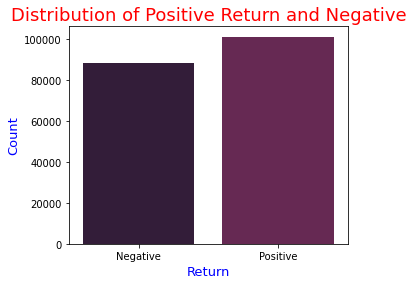

In [10]:
import seaborn as sns
df_cp = data_df.copy()
df_cp['Label'] = df_cp['Label'].replace({0: 'Positive', 1: 'Negative'})
sns.set_palette("rocket")
fig, ax = plt.subplots(figsize=(5,4))
bar = sns.countplot(x=df_cp["Label"],ax=ax)
bar.set_title('Distribution of Positive Return and Negative', fontsize = 18, color = 'red')
bar.set_xlabel('Return', fontsize = 13, color = 'blue')
bar.set_ylabel('Count', fontsize = 13, color ='blue')
plt.show()

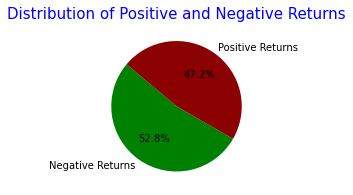

In [11]:
# Count occurrences of positive and negative returns
positive_count = (df_cp["Return"] >= 0).sum()
negative_count = (df_cp["Return"] < 0).sum()

# Create a pie chart for positive and negative returns
sizes = [negative_count, positive_count]
labels = ['Negative Returns', 'Positive Returns']
colors = ['green', 'darkred']

plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Positive and Negative Returns", fontsize=15, color='blue')

plt.show()

## CNN baseline model

In [12]:
cold_start = True

if cold_start:
  #image_train_val_data = np.concatenate(image_train_val_arr, 0)
  image_train_val_data[image_train_val_data==255]=1
  #label_train_val_data = np.concatenate(label_train_val_arr, 0)

  image_train_data, image_val_data = image_train_val_data[:int(0.7*len(image_train_val_data))], image_train_val_data[int(0.7*len(image_train_val_data)):]
  label_train_data, label_val_data = label_train_val_data[:int(0.7*len(label_train_val_data))], label_train_val_data[int(0.7*len(label_train_val_data)):]

  np.save('train_x.npy', image_train_data)
  np.save('train_y.npy', label_train_data)
  np.save('val_x.npy', image_val_data)
  np.save('val_y.npy', label_val_data)

  #image_test_data = np.concatenate(image_test_arr, 0)
  image_test_data[image_test_data==255]=1
  #label_test_data = np.concatenate(label_test_arr, 0)

  np.save('test_x.npy', image_test_data)
  np.save('test_y.npy', label_test_data)

else:
  image_train_data = np.load("train_x.npy")
  image_val_data = np.load("val_x.npy")
  label_train_data = np.load("train_y.npy")
  label_val_data = np.load("val_y.npy")
  image_test_data = np.load("test_x.npy")
  label_test_data = np.load("test_y.npy")

In [13]:
print("The size of training image is " + str(image_train_data.shape))
print("The size of training label is " + str(label_train_data.shape))
print("The size of validation image is " + str(image_val_data.shape))
print("The size of validation label is " + str(label_val_data.shape))
print("The size of testing image is " + str(image_test_data.shape))
print("The size of testing label is " + str(label_test_data.shape))

The size of training image is (106324, 101, 207)
The size of training label is (106324,)
The size of validation image is (45568, 101, 207)
The size of validation label is (45568,)
The size of testing image is (37973, 101, 207)
The size of testing label is (37973,)


In [14]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch

class ImageDataset(Dataset):
    def __init__(self, data_file_path, label_file_path, binary=True):
        self.data = np.load(data_file_path)
        self.label = np.load(label_file_path)
        self.binary = binary
    def __getitem__(self, index):
        x = self.data[index]
        y = self.label[index]
        x = torch.from_numpy(x).float()
        x = x.unsqueeze(0)
        if self.binary:
            y = np.where(y > 0, 1, 0)
        y = torch.from_numpy(y).float()
        return x, y
    
    def __len__(self):
        return len(self.data)

class ImgDataset(Dataset):
    def __init__(self, data_file, label_file, binary=True):
        self.data = data_file
        self.label = label_file
        self.binary = binary
    def __getitem__(self, index):
        x = self.data[index]
        y = self.label[index]
        x = torch.from_numpy(x).float()
        x = x.unsqueeze(0)
        if self.binary:
            y = np.where(y > 0, 1, 0)
        y = torch.from_numpy(y).float()
        return x,y
    
    def __len__(self):
        return len(self.data)

In [15]:
import torch
from torch import nn
import torch.nn.functional as F
class ConvNet(nn.Module):
    """Encoder for feature embedding"""
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size=(5,3), padding=(0, 1), stride=(1,1) ,dilation=(4,1)),
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU(0.01),
                        nn.MaxPool2d(kernel_size  = (2, 1), stride=(2,1)))
        nn.init.xavier_uniform_(self.layer1[0].weight)
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,kernel_size=(5,3),padding=(0,1), stride=(1,1), dilation=(1,1)),
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(0.01),
                        nn.MaxPool2d(kernel_size  = (2, 1), stride=(2,1)),)
        nn.init.xavier_uniform_(self.layer2[0].weight)
        self.layer3 = nn.Sequential(
                        nn.Conv2d(128,256,kernel_size=(5,3),padding=(0,1), stride=(1,1), dilation=(1,1)),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(0.01),
                        nn.MaxPool2d(kernel_size  = (2, 1), stride=(2,1)),)
        nn.init.xavier_uniform_(self.layer3[0].weight)
        self.layer4 = nn.Sequential(
                        nn.Conv2d(256,512,kernel_size=(5,3),padding=(0,1), stride=(1,1), dilation=(1,1)),
                        nn.BatchNorm2d(512),
                        nn.LeakyReLU(0.01),
                        nn.MaxPool2d(kernel_size  = (2, 1), stride=(2,1)),)
        nn.init.xavier_uniform_(self.layer4[0].weight)
        self.fc1 = nn.Sequential(
            nn.Linear(512*1*207, 2),  
            nn.Dropout(p=0.5),  
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.shape[0],-1)
        result = self.fc1(out)
        result = self.softmax(result)

        return result

def conv3():
    return ConvNet()

model = conv3()
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 3), stride=(1, 1), padding=(0, 1), dilation=(4, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(0, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 1), padding=(0, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=Fal

In [16]:
from torchsummary import summary
summary(model.to('cuda'), input_size=(1, 101, 207), device="cuda" )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 85, 207]           1,024
       BatchNorm2d-2          [-1, 64, 85, 207]             128
         LeakyReLU-3          [-1, 64, 85, 207]               0
         MaxPool2d-4          [-1, 64, 42, 207]               0
            Conv2d-5         [-1, 128, 38, 207]         123,008
       BatchNorm2d-6         [-1, 128, 38, 207]             256
         LeakyReLU-7         [-1, 128, 38, 207]               0
         MaxPool2d-8         [-1, 128, 19, 207]               0
            Conv2d-9         [-1, 256, 15, 207]         491,776
      BatchNorm2d-10         [-1, 256, 15, 207]             512
        LeakyReLU-11         [-1, 256, 15, 207]               0
        MaxPool2d-12          [-1, 256, 7, 207]               0
           Conv2d-13          [-1, 512, 3, 207]       1,966,592
      BatchNorm2d-14          [-1, 512,

In [17]:
import torch
import numpy as np
import random
import os
from copy import deepcopy
import math
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

class Averager():

    def __init__(self):
        self.n = 0
        self.v = 0

    def add(self, x):
        self.v = (self.v * self.n + x) / (self.n + 1)
        self.n += 1

    def item(self):
        return self.v


def pretrain(model, loader, optimizer, device):
    model.train()
    ## training with ce
    loss_avg = Averager() 
    for batch_idx, batch in enumerate(loader):
        model.zero_grad()
        optimizer.zero_grad()
        train_inputs, train_targets = batch[0], batch[1]
        train_targets = train_targets.long()
        train_inputs = train_inputs.to(device=device)
        train_targets = train_targets.to(device=device)
        train_logits = model(train_inputs)
        loss = nn.CrossEntropyLoss()(train_logits, train_targets)
        loss_avg.add(loss.item())
        loss.backward()
        optimizer.step()
    print("Train Loss %.4f" % (loss_avg.item()))
    return loss_avg.item()

def evaluate_batch(model, data_loader, device):
    model.eval()
    correct = num = 0
    for iter, pack in enumerate(data_loader):
        data, target = pack[0].to(device), pack[1].to(device)
        targets = target.long()
        logits = model(data)
        _, pred = logits.max(1)
        correct += pred.eq(target).sum().item()
        num += data.shape[0]  
    torch.cuda.empty_cache()
    model.train()
    return correct/num


def get_confusion(model, data_loader, device):
    model.eval()
    correct = num = 0
    y_true = []
    y_pred = []
    for iter, pack in enumerate(data_loader):
        data, target = pack[0].to(device), pack[1].to(device)
        targets = target.long()
        logits = model(data)
        _, pred = logits.max(1)
        y_true.append(target.item())
        y_pred.append(pred.item())
        correct += pred.eq(target).sum().item()
        num += data.shape[0]  
    torch.cuda.empty_cache()
    print(y_true)
    print(y_pred)
    model.train()
    return confusion_matrix(y_true, y_pred)   

Epoch :  1
Train Loss 0.7759
Val Acc :  0.5335103581460674
Epoch :  2
Train Loss 0.7754
Val Acc :  0.5335103581460674
Epoch :  3
Train Loss 0.7754
Val Acc :  0.5335103581460674
Epoch :  4
Train Loss 0.7747
Val Acc :  0.5335103581460674
Epoch :  5
Train Loss 0.7743
Val Acc :  0.5335103581460674


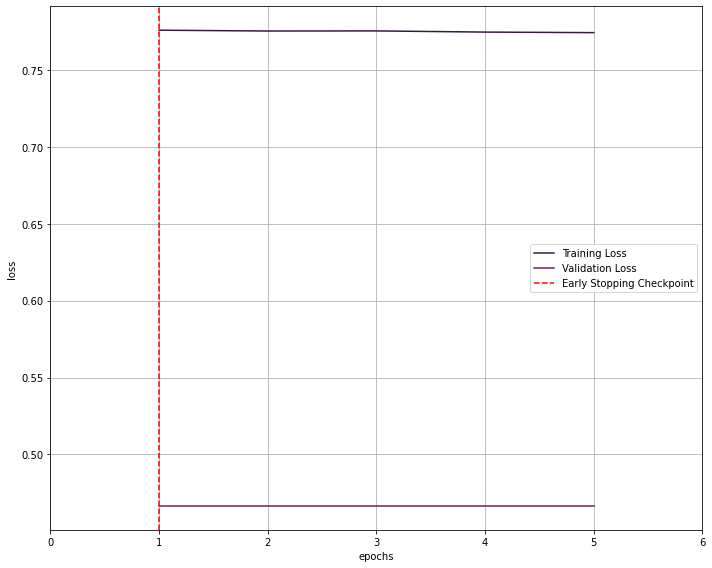

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import  os 



trainset = ImageDataset("train_x.npy","train_y.npy")
valset = ImageDataset("val_x.npy","val_y.npy")

batch_size = 1
epoch = 15
lr = 1e-3
wd =  5e-4
model_name = 'weight.pth'
train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=0,
                pin_memory=True, drop_last=True)
val_loader = DataLoader(dataset=valset, batch_size=batch_size, shuffle=False, num_workers=0,
                pin_memory=True, drop_last=True)




device = 'cuda'
model = conv3().cuda()
optimizer=torch.optim.AdamW(model.parameters(), lr, weight_decay=wd)
evaluate_batch(model, val_loader, device)
best_acc = 0
count = 0

train_losses = []
valid_losses = []

for i in range(1, epoch+1):
    print('Epoch : ', i)
    train_loss = pretrain(model, train_loader, optimizer, device)
    train_losses.append(train_loss)
    val_acc = evaluate_batch(model, val_loader, device)
    valid_losses.append(1-val_acc)
    print('Val Acc : ', val_acc)
    if  best_acc < val_acc:
        count = 0
        best_acc = val_acc
        torch.save(model.state_dict(), model_name)
    else:
        count += 1
    if count >= 4:
        break


# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_losses)+1),train_losses, label='Training Loss')
plt.plot(range(1,len(valid_losses)+1),valid_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_losses.index(min(valid_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
# plt.ylim(0, 1) # consistent scale
plt.xlim(0, len(train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [19]:
import itertools
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
testset = ImageDataset("test_x.npy","test_y.npy")
test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=0,
                pin_memory=True, drop_last=True)
test_acc = evaluate_batch(model, test_loader, device)
print('Test Acc : ', test_acc)
test_matrix = get_confusion(model, test_loader, device)
classes = ['Positive', 'Negative']

plot_confusion_matrix(test_matrix, classes=classes, normalize=False, title='Normalized confusion matrix')

Test Acc :  0.5333263107997788


In [ ]:
def calculate_f1_score(confusion_matrix):
    TN, FP, FN, TP = confusion_matrix.ravel()

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    f1_score = 2 * (precision * recall) / (precision + recall + 1e-9)
    return f1_score

In [ ]:
f1_score = calculate_f1_score(test_matrix)
print("F1 Score:", f1_score)

### Grad-CAM 
please first install the supporting pacakge:

pip install grad-cam

In [ ]:
#pip install grad-cam
from pytorch_grad_cam import GradCAM # or ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad

from pytorch_grad_cam.utils.image import show_cam_on_image


batch_size = 1
epoch = 15
lr = 1e-3
wd =  5e-4

train_x  = np.load("train_x.npy")
train_y = np.load("train_y.npy")
val_x , val_y = np.load("val_x.npy"), np.load("val_y.npy")
trainset = ImgDataset(train_x , train_y )
valset = ImgDataset(val_x , val_y)
model_name = "weight.pth"
train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=0,
                pin_memory=True, drop_last=True)
val_loader = DataLoader(dataset=valset, batch_size=batch_size, shuffle=False, num_workers=0,
                pin_memory=True, drop_last=True)

print(valset)
device = 'cuda'

#load the trained model. Here we assume the weight has been saved
model_name = "weight.pth"
model = conv3()
model.load_state_dict(torch.load(model_name,map_location=torch.device('cuda')))
model.eval()


In [ ]:
device = torch.device("cuda")
model.to(device)
# find 5 images that are classified as 1 or 0
classification_object = 0   # or let classification_object = 1 to get another bunch of images
image_list = []
label_list = []
counter = 0
# better shuffle the data loader
for iter, pack in enumerate(val_loader):
    data, target = pack[0].to(device), pack[1].to(device)
    #targets = target.long()
    logits = model(data)
    _, pred = logits.max(1)
    class_list = data[pred==classification_object,]
    if class_list.size(0) > 0:
        obj = class_list[random.randrange(class_list.size(0)),]
        counter = counter+1
        image_list.append(obj)
        if counter >= 5:
            break

image_list = torch.stack(image_list)


input_tensors = image_list
    

# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
aug_smooth = True
eigen_smooth = True


target_layer_1 = [model.layer1[-1]]
cam_1 = GradCAM(model=model, target_layers=target_layer_1, use_cuda=True)
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam_1 = cam_1(input_tensor=image_list, targets=None ,aug_smooth=aug_smooth,eigen_smooth=eigen_smooth)

#visualization = show_cam_on_image(input_tensors, grayscale_cam, use_rgb=True)

target_layer_2 = [model.layer2[-1]]
cam_2 = GradCAM(model=model, target_layers=target_layer_2, use_cuda=True)
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam_2 = cam_2(input_tensor=image_list, targets=None ,aug_smooth=aug_smooth,eigen_smooth=eigen_smooth)


target_layer_3 = [model.layer3[-1]]
cam_3 = GradCAM(model=model, target_layers=target_layer_3, use_cuda=True)
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam_3 = cam_3(input_tensor=image_list, targets=None ,aug_smooth=aug_smooth,eigen_smooth=eigen_smooth)

target_layer_4 = [model.layer4[-1]]
cam_4 = GradCAM(model=model, target_layers=target_layer_4, use_cuda=True)
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam_4 = cam_4(input_tensor=image_list, targets=None ,aug_smooth=aug_smooth,eigen_smooth=eigen_smooth)

grayscale_cam_1 = torch.from_numpy(grayscale_cam_1).to(device)
grayscale_cam_2 = torch.from_numpy(grayscale_cam_2).to(device)
grayscale_cam_3 = torch.from_numpy(grayscale_cam_3).to(device)
grayscale_cam_4 = torch.from_numpy(grayscale_cam_4).to(device)

camera = torch.cat((image_list[:, 0,], grayscale_cam_1, grayscale_cam_2, grayscale_cam_3, grayscale_cam_4), 0)

#camera = torch.cat((image_list[:,0,], torch.from_numpy(grayscale_cam_1),torch.from_numpy(grayscale_cam_2),torch.from_numpy(grayscale_cam_3),torch.from_numpy(grayscale_cam_4)),0)  

In [ ]:
image_list_cpu = image_list.cpu()
grayscale_cam_1_cpu = grayscale_cam_1.cpu().numpy()
grayscale_cam_2_cpu = grayscale_cam_2.cpu().numpy()
grayscale_cam_3_cpu = grayscale_cam_3.cpu().numpy()
grayscale_cam_4_cpu = grayscale_cam_4.cpu().numpy()

In [ ]:
# show multiple images
camera = camera.cpu().numpy()
fig = plt.figure(figsize=(10, 10))
columns = 5
rows = 4
for i in range(0, columns*rows ):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    if i<= 4:
        plt.imshow(camera[i,],cmap="gray")
    else:
        plt.imshow(camera[i,],cmap="Blues_r")
plt.savefig('4x5.png',format='png')
plt.show()